In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter
from pathlib import Path

def load_and_clean_data(csv_path):
    """
    Load the dataset from CSV file without cleaning
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with annotations
        
    Returns:
    --------
    pd.DataFrame
        Original dataframe with calculated dimensions
    """
    # Read the CSV file
    print(f"Reading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Report missing values without dropping them
    print("Checking for missing values...")
    for col in df.columns:
        missing = df[col].isna().sum()
        if missing > 0:
            print(f"  Column '{col}' has {missing} missing values")
    
    # Calculate object dimensions without cleaning
    df['width'] = df['x_max'] - df['x_min']
    df['height'] = df['y_max'] - df['y_min']
    df['area'] = df['width'] * df['height']
    
    # Handle potential division by zero in aspect ratio calculation
    # but keep NaN values as they are
    df['aspect_ratio'] = df['width'] / df['height']
    
    return df

def print_dataset_stats(df):
    """
    Print basic statistics about the dataset
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    """
    # Print basic information
    print("\n--- DATASET STATISTICS ---")
    print(f"Total entries: {len(df)}")
    print(f"Total unique images: {df['image_id'].nunique()}")
    print(f"Total classes: {df['class_name'].nunique()}")
    
    # Calculate mean objects per image
    objects_per_image = df.groupby('image_id').size()
    print(f"Average objects per image: {objects_per_image.mean():.2f}")
    print(f"Max objects in a single image: {objects_per_image.max()}")
    
    # Print class distribution
    print("\nClass distribution:")
    class_counts = df['class_name'].value_counts()
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} ({count/len(df)*100:.1f}%)")
    
    # Print size statistics
    print("\nSize statistics:")
    print(f"  Average width: {df['width'].mean():.2f}")
    print(f"  Average height: {df['height'].mean():.2f}")
    print(f"  Average area: {df['area'].mean():.2f}")
    print("------------------------\n")
    
    return class_counts, objects_per_image

def plot_class_distribution(df, output_folder):
    """
    Create class distribution plot
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    plt.figure(figsize=(12, 6))
    # Handle potentially missing class_name values by skipping them
    class_counts = df['class_name'].dropna().value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Number of Objects per Class')
    plt.xlabel('Class Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '1_class_distribution.png'))
    plt.close()
    print(f"Saved class distribution plot to {output_folder}/1_class_distribution.png")
    
    return class_counts

def plot_objects_per_image(df, output_folder):
    """
    Create objects per image distribution plot
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    # Use valid image IDs only for this calculation
    objects_per_image = df.dropna(subset=['image_id']).groupby('image_id').size()
    
    plt.figure(figsize=(10, 6))
    try:
        if len(objects_per_image) > 0:
            sns.histplot(objects_per_image, kde=True, bins=30)
            plt.axvline(objects_per_image.mean(), color='red', linestyle='--', 
                        label=f'Mean: {objects_per_image.mean():.2f}')
            plt.title('Distribution of Objects per Image')
            plt.xlabel('Number of Objects')
            plt.ylabel('Frequency')
            plt.legend()
        else:
            plt.text(0.5, 0.5, "No valid image ID data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error creating plot: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '2_objects_per_image.png'))
    plt.close()
    print(f"Saved objects per image distribution plot to {output_folder}/2_objects_per_image.png")
    
    return objects_per_image

def plot_size_distribution(df, output_folder):
    """
    Create object size distribution plots
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    plt.figure(figsize=(15, 5))
    
    # Create a subplot with 1 row and 3 columns
    plt.subplot(1, 3, 1)
    try:
        # Use dropna to handle missing values without modifying original dataframe
        sns.histplot(df['width'].dropna(), kde=True, bins=30)
        plt.title('Width Distribution')
        plt.xlabel('Width')
    except Exception as e:
        plt.text(0.5, 0.5, f"Error: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.subplot(1, 3, 2)
    try:
        sns.histplot(df['height'].dropna(), kde=True, bins=30)
        plt.title('Height Distribution')
        plt.xlabel('Height')
    except Exception as e:
        plt.text(0.5, 0.5, f"Error: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.subplot(1, 3, 3)
    try:
        sns.histplot(df['area'].dropna(), kde=True, bins=30)
        plt.title('Area Distribution')
        plt.xlabel('Area')
    except Exception as e:
        plt.text(0.5, 0.5, f"Error: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '3_size_distribution.png'))
    plt.close()
    print(f"Saved size distribution plots to {output_folder}/3_size_distribution.png")

def plot_position_heatmap(df, output_folder):
    """
    Create object position heatmap
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    plt.figure(figsize=(10, 10))
    
    try:
        # Calculate center positions
        x_centers = df['x_min'] + df['width']/2
        y_centers = df['y_min'] + df['height']/2
        
        # Drop NaN values for plotting without modifying original dataframe
        valid_x = x_centers.dropna()
        valid_y = y_centers.dropna()
        
        # Get indices that are valid in both x and y
        valid_indices = valid_x.index.intersection(valid_y.index)
        
        if len(valid_indices) > 0:
            plt.hist2d(x_centers[valid_indices], y_centers[valid_indices], bins=50, cmap='viridis')
            plt.colorbar(label='Frequency')
        else:
            plt.text(0.5, 0.5, "Insufficient valid position data", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error creating heatmap: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.title('Object Center Position Heatmap')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '4_position_heatmap.png'))
    plt.close()
    print(f"Saved position heatmap to {output_folder}/4_position_heatmap.png")

def plot_class_size_comparison(df, output_folder):
    """
    Create class size comparison plot
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    plt.figure(figsize=(12, 8))
    try:
        # Create temporary view for plotting without modifying original
        temp_df = df[['class_name', 'area']].dropna()
        
        if len(temp_df) > 0:
            sns.boxplot(x='class_name', y='area', data=temp_df)
            plt.title('Object Size by Class')
            plt.xlabel('Class Name')
            plt.ylabel('Area')
            plt.xticks(rotation=45, ha='right')
        else:
            plt.text(0.5, 0.5, "Insufficient class or area data", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error creating boxplot: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '5_class_size_comparison.png'))
    plt.close()
    print(f"Saved class size comparison plot to {output_folder}/5_class_size_comparison.png")

def plot_aspect_ratio_distribution(df, output_folder):
    """
    Create aspect ratio distribution plot
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    output_folder : str
        Folder to save the generated graph
    """
    plt.figure(figsize=(10, 6))
    try:
        # Plotting aspect ratio without modifying original data
        valid_aspect_ratios = df['aspect_ratio'].dropna()
        
        if len(valid_aspect_ratios) > 0:
            # Plot but clip to reasonable range for visualization
            sns.histplot(valid_aspect_ratios.clip(0.1, 10), kde=True, bins=30)
            plt.title('Object Aspect Ratio Distribution')
            plt.xlabel('Aspect Ratio (width/height)')
            plt.ylabel('Frequency')
        else:
            plt.text(0.5, 0.5, "No valid aspect ratio data available", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error creating aspect ratio plot: {str(e)}", 
                ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'bonus_aspect_ratio.png'))
    plt.close()
    print(f"Saved aspect ratio distribution plot to {output_folder}/bonus_aspect_ratio.png")

def save_summary_txt(df, class_counts, objects_per_image, output_folder):
    """
    Save dataset summary to text file
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset dataframe
    class_counts : pd.Series
        Counts of objects per class
    objects_per_image : pd.Series
        Counts of objects per image
    output_folder : str
        Folder to save the summary file
    """
    # Generate text summary
    summary = {
        'total_images': df['image_id'].nunique(),
        'total_objects': len(df),
        'total_classes': df['class_name'].nunique(),
        'avg_objects_per_image': objects_per_image.mean(),
        'class_distribution': class_counts.to_dict(),
        'avg_object_width': df['width'].mean(),
        'avg_object_height': df['height'].mean(),
        'avg_object_area': df['area'].mean(),
    }
    
    # Save summary to text file
    with open(os.path.join(output_folder, 'dataset_summary.txt'), 'w') as f:
        f.write("Dataset Summary\n")
        f.write("==============\n\n")
        f.write(f"Total Images: {summary['total_images']}\n")
        f.write(f"Total Objects: {summary['total_objects']}\n")
        f.write(f"Total Classes: {summary['total_classes']}\n")
        f.write(f"Average Objects per Image: {summary['avg_objects_per_image']:.2f}\n\n")
        
        f.write("Class Distribution:\n")
        for class_name, count in summary['class_distribution'].items():
            f.write(f"  {class_name}: {count} ({count/summary['total_objects']*100:.1f}%)\n")
        
        f.write(f"\nAverage Object Width: {summary['avg_object_width']:.2f}\n")
        f.write(f"Average Object Height: {summary['avg_object_height']:.2f}\n")
        f.write(f"Average Object Area: {summary['avg_object_area']:.2f}\n")
    
    print(f"Saved dataset summary to {output_folder}/dataset_summary.txt")

def analyze_dataset(csv_path, output_folder="analysis_results"):
    """
    Analyze the dataset and generate informative graphs
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file with annotations
    output_folder : str
        Folder to save the generated graphs
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Load and clean data
    df = load_and_clean_data(csv_path)
    
    # Print dataset statistics
    class_counts, objects_per_image = print_dataset_stats(df)
    
    # Generate all plots
    plot_class_distribution(df, output_folder)
    plot_objects_per_image(df, output_folder)
    plot_size_distribution(df, output_folder)
    plot_position_heatmap(df, output_folder)
    plot_class_size_comparison(df, output_folder)
    plot_aspect_ratio_distribution(df, output_folder)
    
    # Save summary to text file
    save_summary_txt(df, class_counts, objects_per_image, output_folder)
    
    print(f"\nAnalysis completed! All results saved to {output_folder} folder")

# Example usage - you can call individual functions if you want
if __name__ == "__main__":
    # Set the path to your CSV file
    csv_path = "train.csv"
    
    # Run the complete analysis
    analyze_dataset(csv_path)
    
    # Or run specific functions (commented out by default)
    """
    # Create output folder
    output_folder = "analysis_results"
    os.makedirs(output_folder, exist_ok=True)
    
    # Load data
    df = load_and_clean_data(csv_path)
    
    # Print stats only
    class_counts, objects_per_image = print_dataset_stats(df)
    
    # Generate only specific plots
    plot_class_distribution(df, output_folder)
    plot_position_heatmap(df, output_folder)
    """

Reading data from train.csv...
Checking for missing values...
  Column 'x_min' has 31818 missing values
  Column 'y_min' has 31818 missing values
  Column 'x_max' has 31818 missing values
  Column 'y_max' has 31818 missing values
  Column 'raw_x_min' has 31818 missing values
  Column 'raw_x_max' has 31818 missing values
  Column 'raw_y_min' has 31818 missing values
  Column 'raw_y_max' has 31818 missing values

--- DATASET STATISTICS ---
Total entries: 67914
Total unique images: 15000
Total classes: 15
Average objects per image: 4.53
Max objects in a single image: 57

Class distribution:
  No finding: 31818 (46.9%)
  Aortic enlargement: 7162 (10.5%)
  Cardiomegaly: 5427 (8.0%)
  Pleural thickening: 4842 (7.1%)
  Pulmonary fibrosis: 4655 (6.9%)
  Nodule/Mass: 2580 (3.8%)
  Lung Opacity: 2483 (3.7%)
  Pleural effusion: 2476 (3.6%)
  Other lesion: 2203 (3.2%)
  Infiltration: 1247 (1.8%)
  ILD: 1000 (1.5%)
  Calcification: 960 (1.4%)
  Consolidation: 556 (0.8%)
  Atelectasis: 279 (0.4%)
  

All the Plots are in  analysis_results folder

Total unique images in dataset: 15000
Randomly selected 3 images from dataset

--- Image 1/3 ---
Objects in image 989c65929da5fa0297db8da6945cca52:
  - No finding: 3

--- Image 2/3 ---
Objects in image ed696103132aee457b0e11ce0d7b7d27:
  - Pleural effusion: 4
  - Lung Opacity: 3
  - Infiltration: 1
  - ILD: 1

--- Image 3/3 ---
Objects in image bcd6cd9307ee7945c1abc475aac46f86:
  - No finding: 3


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


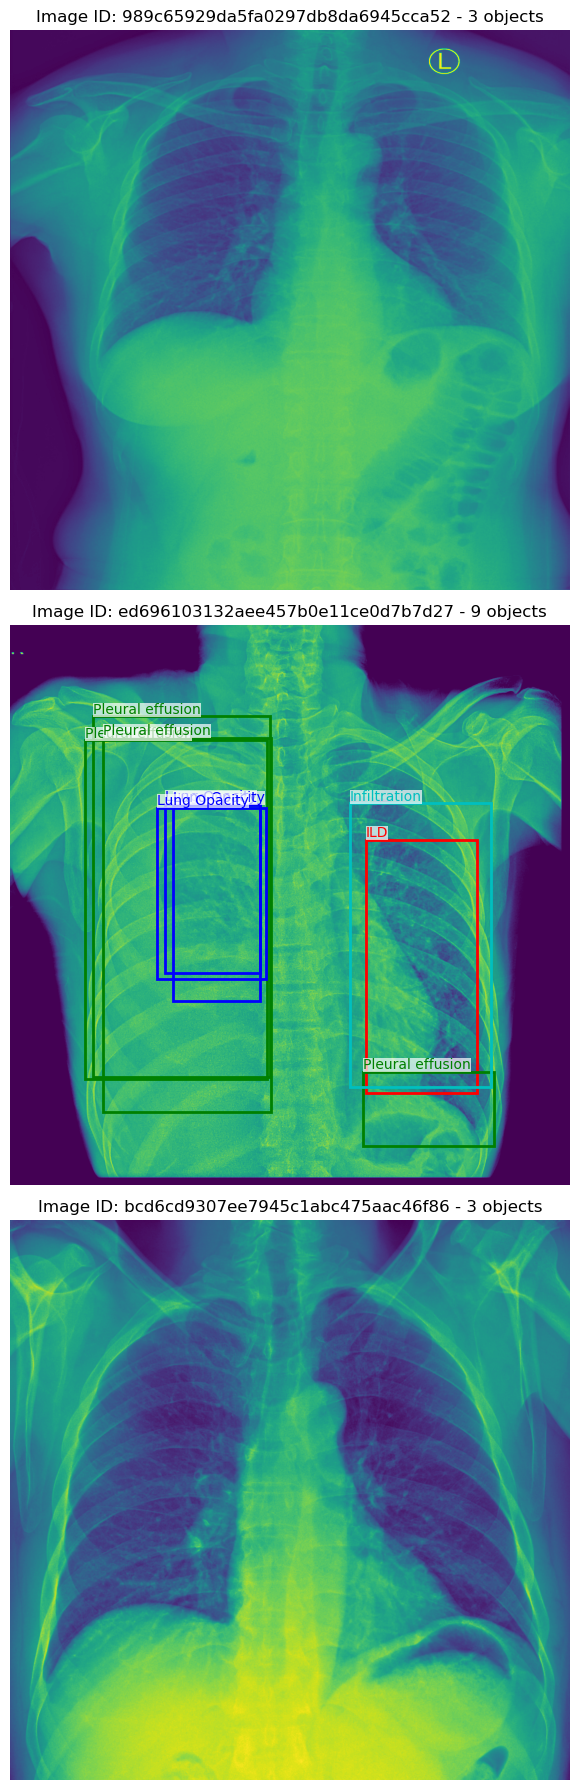

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import pandas as pd
import os
import random

def display_random_images_with_bboxes(df, num_images=3, figsize=(15, 18)):
    """
    Display a fixed number of random images with their bounding boxes using coordinates from train.csv
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing bounding box annotations from train.csv
        Must have columns: image_id, class_name, x_min, y_min, x_max, y_max
    num_images : int
        Number of random images to display (default: 3)
    figsize : tuple
        Figure size (width, height) in inches
    """
    # Get unique image IDs
    unique_image_ids = df['image_id'].unique()
    print(f"Total unique images in dataset: {len(unique_image_ids)}")
    
    # Select random images
    if len(unique_image_ids) <= num_images:
        selected_ids = unique_image_ids
        print("Dataset has fewer images than requested. Displaying all available images.")
    else:
        selected_ids = random.sample(list(unique_image_ids), num_images)
        print(f"Randomly selected {num_images} images from dataset")
    
    # Create subplot grid
    fig, axes = plt.subplots(num_images, 1, figsize=figsize)
    
    # If only one image is requested, make axes a list for consistent indexing
    if num_images == 1:
        axes = [axes]
    
    # Display each selected image
    for i, image_id in enumerate(selected_ids):
        print(f"\n--- Image {i+1}/{len(selected_ids)} ---")
        
        # Get current axis
        ax = axes[i]
        
        # Try to display image
        try:
            # Filter dataframe for this image
            image_df = df[df['image_id'] == image_id]
            
            if len(image_df) == 0:
                print(f"No annotations found for image ID: {image_id}")
                ax.text(0.5, 0.5, f"No annotations for image ID: {image_id}", 
                        ha='center', va='center', transform=ax.transAxes)
                continue
            
            # Construct image path using standard format
            image_path = "train/" + image_id + ".jpg"
                
            # Load and display image
            img = Image.open(image_path)
            img_array = np.array(img)
            ax.imshow(img_array)
            
            # Define colors for different classes
            colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
            classes = image_df['class_name'].unique()
            class_color_map = {cls: colors[i % len(colors)] for i, cls in enumerate(classes)}
            
            # Plot bounding boxes using CSV file coordinates
            for _, row in image_df.iterrows():
                # Extract coordinates directly from CSV file
                x_min = row['x_min']  # These are the coordinates from your train.csv file
                y_min = row['y_min']  # These are the coordinates from your train.csv file
                x_max = row['x_max']  # These are the coordinates from your train.csv file
                y_max = row['y_max']  # These are the coordinates from your train.csv file
                
                # Calculate width and height
                width = x_max - x_min
                height = y_max - y_min
                
                # Get class name and color
                class_name = row['class_name']  # Class name from your train.csv file
                color = class_color_map[class_name]
                
                # Add rectangle using the coordinates from your CSV file
                rect = patches.Rectangle(
                    (x_min, y_min), width, height, 
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)
                
                # Add label
                ax.text(
                    x_min, y_min - 5, class_name, 
                    color=color, fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0)
                )
            
            # Set title and turn off axis
            ax.set_title(f"Image ID: {image_id} - {len(image_df)} objects")
            ax.axis('off')
            
            # Print object summary
            print(f"Objects in image {image_id}:")
            class_summary = image_df['class_name'].value_counts()
            for cls, count in class_summary.items():
                print(f"  - {cls}: {count}")
                
        except Exception as e:
            print(f"Error displaying image {image_id}: {str(e)}")
            ax.text(0.5, 0.5, f"Error loading image: {str(e)}", 
                    ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_csv("train.csv")
    
    # Display 3 random images with bounding boxes (default)
    display_random_images_with_bboxes(df)
    
    # You can also specify a different number of images
    # display_random_images_with_bboxes(df, num_images=5)